# Gaussian Mixture Models

Probabilistic clustering with EM algorithm using sklearn.

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs, make_moons
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)
np.random.seed(42)

---
## Generate Data

In [2]:
X, y_true = make_blobs(n_samples=300, centers=3, n_features=2, 
                       cluster_std=[1.0, 1.5, 0.5], random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f'Data shape: {X.shape}')
print(f'True clusters: {len(np.unique(y_true))}')

Data shape: (300, 2)
True clusters: 3


---
## Fit GMM

In [3]:
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm.fit(X_scaled)

# Predict cluster labels (hard assignment)
labels = gmm.predict(X_scaled)

# Get probabilities (soft assignment)
probs = gmm.predict_proba(X_scaled)

print('='*60)
print('GAUSSIAN MIXTURE MODEL')
print('='*60)
print(f'Components: {gmm.n_components}')
print(f'Converged: {gmm.converged_}')
print(f'Iterations: {gmm.n_iter_}')
print(f'Log-likelihood: {gmm.score(X_scaled) * len(X_scaled):.2f}')
print(f'\nMixing coefficients (weights): {gmm.weights_}')
print(f'\nFirst 5 soft assignments:')
print(probs[:5])

GAUSSIAN MIXTURE MODEL
Components: 3
Converged: True
Iterations: 2
Log-likelihood: -56.62

Mixing coefficients (weights): [0.3333333  0.33333333 0.33333336]

First 5 soft assignments:
[[5.40451419e-064 1.00000000e+000 8.91444316e-027]
 [8.52314797e-063 1.00000000e+000 1.07844136e-026]
 [9.99999760e-001 3.30138003e-203 2.40459560e-007]
 [1.61072638e-021 6.56101119e-186 1.00000000e+000]
 [1.25876600e-065 1.00000000e+000 4.62322650e-028]]


---
## Visualize Clusters and Gaussian Components

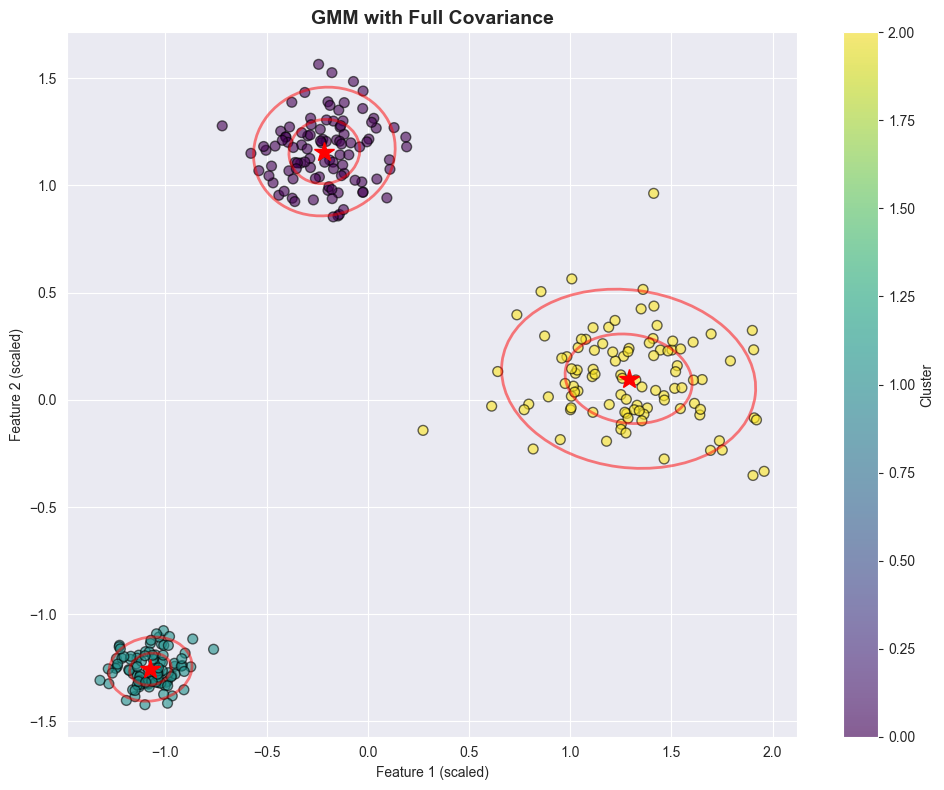

In [4]:
def plot_gmm(gmm, X, labels, title):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot data points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', 
                        s=50, alpha=0.6, edgecolors='k')
    
    # Plot Gaussian ellipses
    for i in range(gmm.n_components):
        mean = gmm.means_[i]
        covar = gmm.covariances_[i]
        
        # Eigenvalues and eigenvectors for ellipse
        v, w = np.linalg.eigh(covar)
        angle = np.degrees(np.arctan2(w[1, 0], w[0, 0]))
        
        # Draw 2-std ellipse
        for std_mult in [1, 2]:
            ell = Ellipse(mean, 2 * std_mult * np.sqrt(v[0]), 
                         2 * std_mult * np.sqrt(v[1]),
                         angle=angle, facecolor='none', 
                         edgecolor='red', linewidth=2, alpha=0.5)
            ax.add_patch(ell)
        
        # Plot mean
        ax.plot(mean[0], mean[1], 'r*', markersize=15)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Feature 1 (scaled)')
    ax.set_ylabel('Feature 2 (scaled)')
    plt.colorbar(scatter, label='Cluster')
    plt.tight_layout()
    plt.show()

plot_gmm(gmm, X_scaled, labels, 'GMM with Full Covariance')

---
## Soft vs Hard Clustering

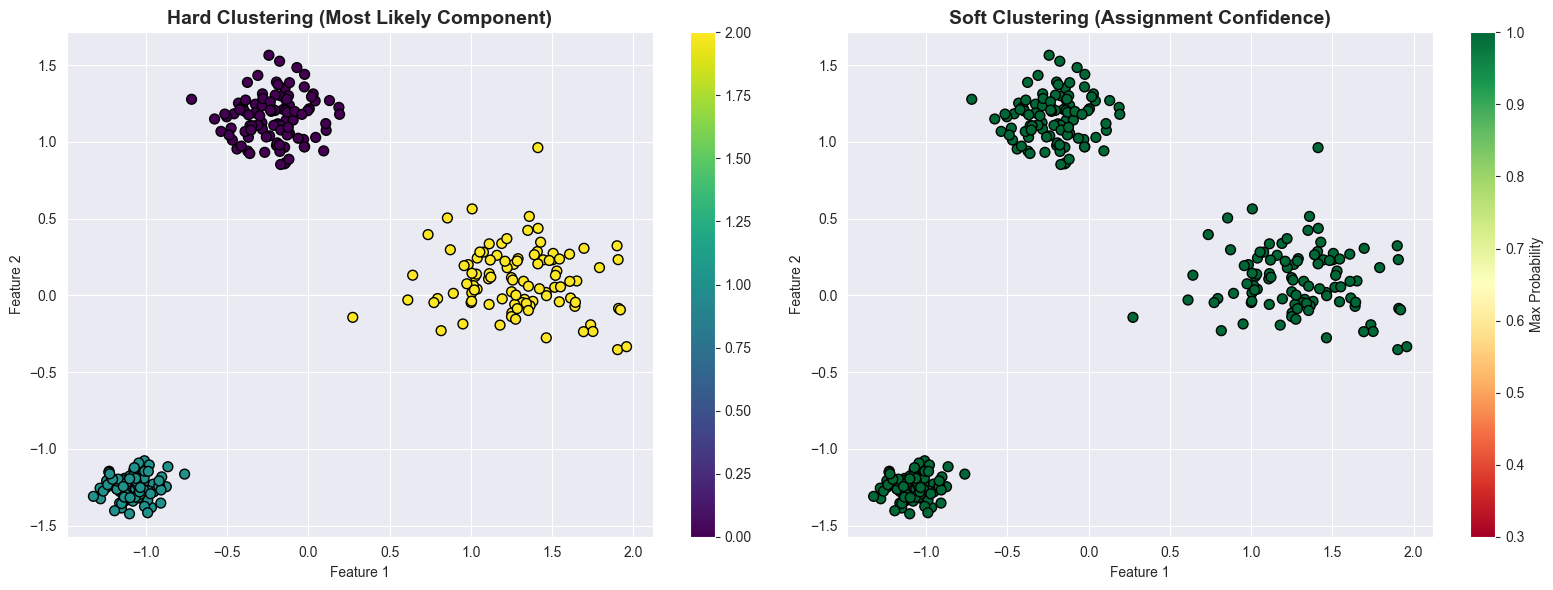

Uncertain points (max prob < 0.7): 0
Red points = uncertain, green = confident


In [5]:
# Visualize uncertainty
max_probs = probs.max(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Hard clustering
scatter1 = axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, 
                          cmap='viridis', s=50, edgecolors='k')
axes[0].set_title('Hard Clustering (Most Likely Component)', 
                 fontsize=14, fontweight='bold')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
plt.colorbar(scatter1, ax=axes[0])

# Soft clustering (colored by confidence)
scatter2 = axes[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=max_probs, 
                          cmap='RdYlGn', s=50, edgecolors='k', vmin=0.3, vmax=1.0)
axes[1].set_title('Soft Clustering (Assignment Confidence)', 
                 fontsize=14, fontweight='bold')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
plt.colorbar(scatter2, ax=axes[1], label='Max Probability')

plt.tight_layout()
plt.show()

print(f'Uncertain points (max prob < 0.7): {np.sum(max_probs < 0.7)}')
print('Red points = uncertain, green = confident')

---
## Model Selection with BIC

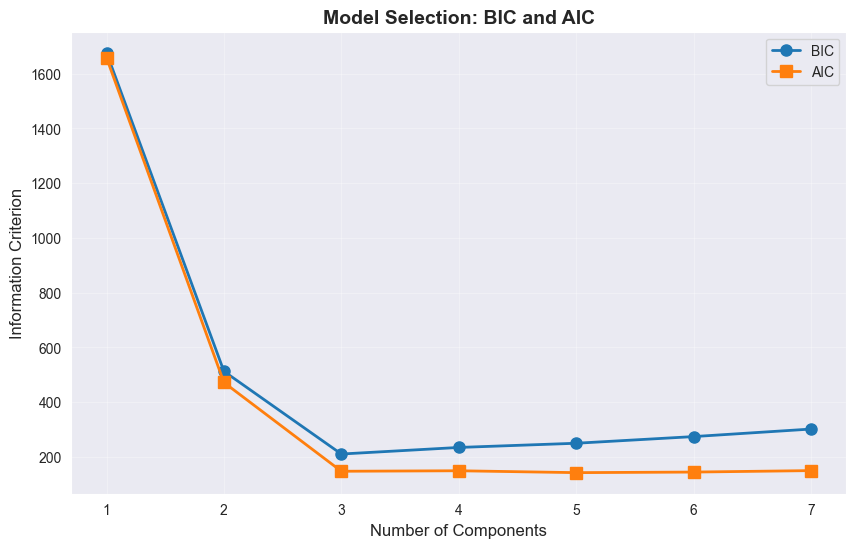

Optimal K (BIC): 3
Optimal K (AIC): 5
Lower is better. BIC penalizes complexity more.


In [6]:
n_components_range = range(1, 8)
bic_scores = []
aic_scores = []

for n in n_components_range:
    gmm_temp = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm_temp.fit(X_scaled)
    bic_scores.append(gmm_temp.bic(X_scaled))
    aic_scores.append(gmm_temp.aic(X_scaled))

plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_scores, 'o-', linewidth=2, label='BIC', markersize=8)
plt.plot(n_components_range, aic_scores, 's-', linewidth=2, label='AIC', markersize=8)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Information Criterion', fontsize=12)
plt.title('Model Selection: BIC and AIC', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

optimal_k_bic = n_components_range[np.argmin(bic_scores)]
optimal_k_aic = n_components_range[np.argmin(aic_scores)]
print(f'Optimal K (BIC): {optimal_k_bic}')
print(f'Optimal K (AIC): {optimal_k_aic}')
print('Lower is better. BIC penalizes complexity more.')

---
## Covariance Types Comparison

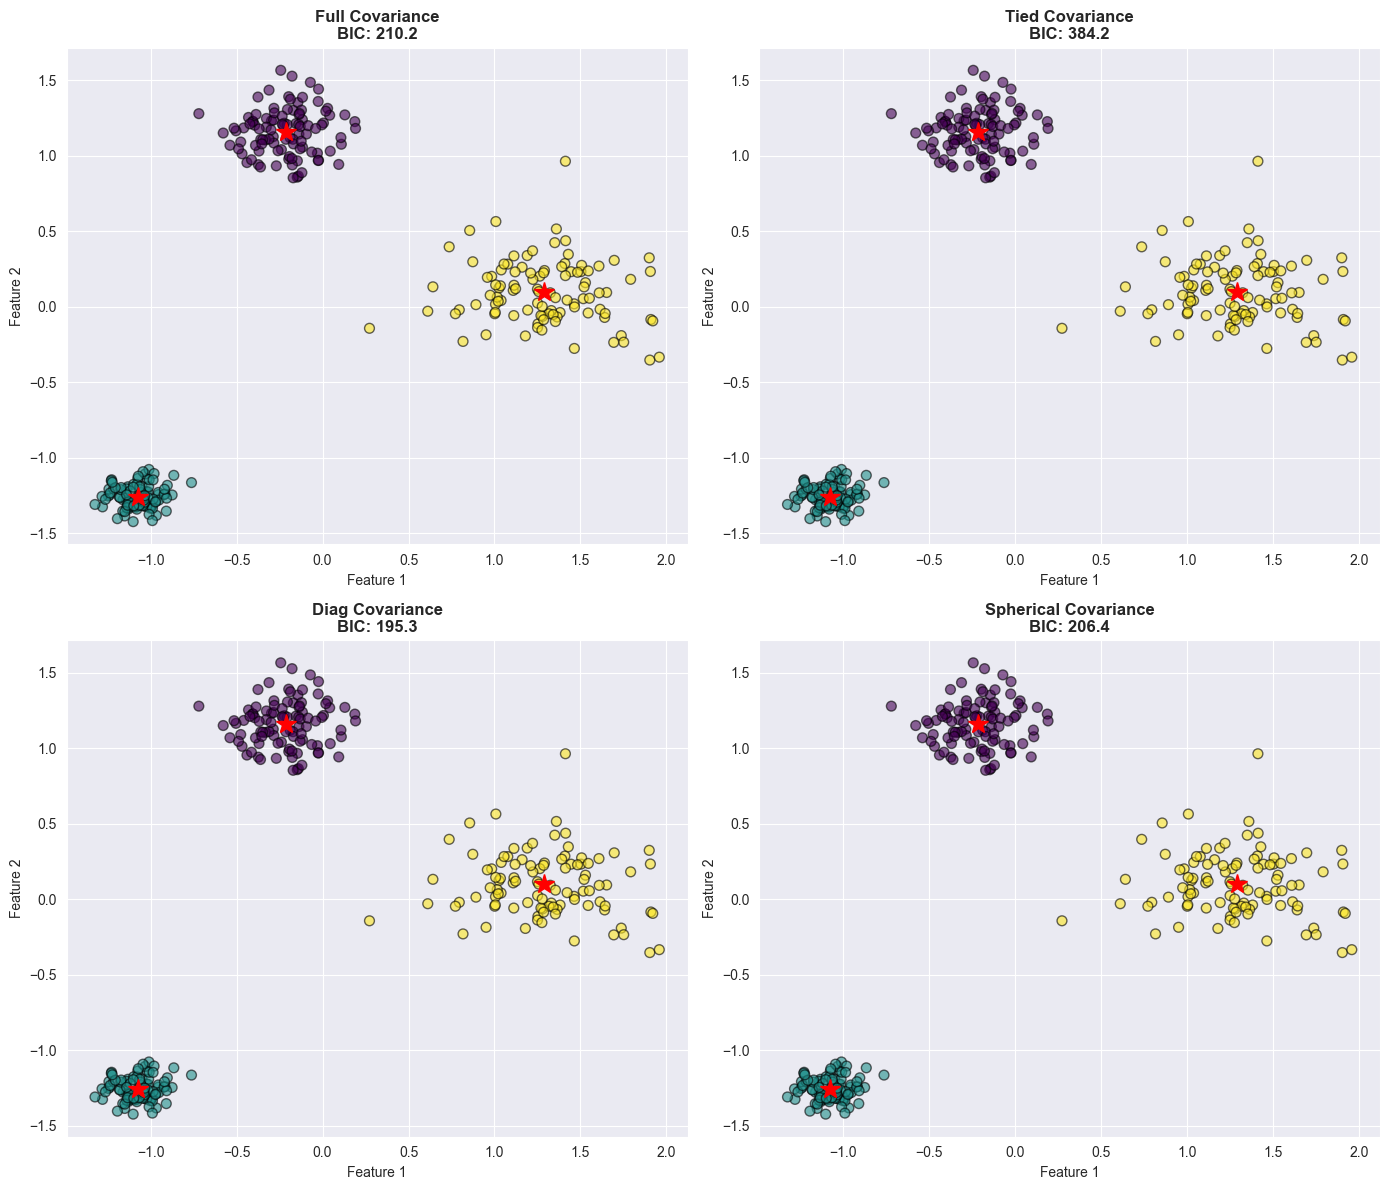

Full: Most flexible, any orientation
Tied: Same shape for all components
Diagonal: Axis-aligned ellipses
Spherical: Circular clusters (like K-Means)


In [7]:
cov_types = ['full', 'tied', 'diag', 'spherical']
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, cov_type in enumerate(cov_types):
    gmm_cov = GaussianMixture(n_components=3, covariance_type=cov_type, random_state=42)
    gmm_cov.fit(X_scaled)
    labels_cov = gmm_cov.predict(X_scaled)
    
    axes[idx].scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_cov, 
                     cmap='viridis', s=50, alpha=0.6, edgecolors='k')
    
    # Simple ellipse visualization
    for i in range(3):
        mean = gmm_cov.means_[i]
        axes[idx].plot(mean[0], mean[1], 'r*', markersize=15)
    
    axes[idx].set_title(f'{cov_type.capitalize()} Covariance\nBIC: {gmm_cov.bic(X_scaled):.1f}',
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Feature 1')
    axes[idx].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

print('Full: Most flexible, any orientation')
print('Tied: Same shape for all components')
print('Diagonal: Axis-aligned ellipses')
print('Spherical: Circular clusters (like K-Means)')

---
## Summary

**Key Points:**
- GMM provides probabilistic soft clustering
- EM algorithm fits Gaussian mixture
- BIC/AIC for model selection (number of components)
- Covariance type controls cluster shape flexibility
- Captures uncertainty in assignments

**Key Point:** "GMM models data as mixture of Gaussians, providing soft probabilistic cluster assignments. EM algorithm iteratively updates component parameters. BIC helps select optimal number of components."